In [1]:
#%load_ext snakeviz

# Set seeds for repeatability.
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)


# Import data processing modules.
import pandas as pd
import numpy as np

# Import machine learning modules.
import tensorflow as tf
from tensorflow import keras

import keras

from keras import layers
from keras import optimizers
from keras import regularizers
from keras import initializers

import sklearn

import wandb
from wandb.keras import WandbCallback

# Import Omphalos modules.
import generate_inputs as gi
import file_methods as fm
import my_metrics as mm
import omphalos_plotter as op
import attributes as attr
import labels as lbls

# Import data visualisation modules.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn.preprocessing as skp

print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)

2.3.1
2.4.3
0.23.2


### Import and extract data

In [7]:
train_set = fm.unpickle('pure_train.pickle')
test_set = fm.unpickle('pure_test.pickle')

In [8]:
attributes_df = attr.initial_conditions(train_set, primary_species=True, mineral_vols=True)
attributes_df.drop(columns=['X', 'Y', 'Z', 'C5H7O2NSO4'], inplace=True)

In [9]:
#labels_df = lbls.raw_labels(train_set, 'saturation')
labels_df = lbls.secondary_precip(train_set)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:6390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [87]:
# Nifty oneliner to check if a species has been randomised.
attributes_df.describe().loc['std'] >= 1e-15

Fe++                 False
Fe+++                False
SiO2(aq)             False
Na+                   True
Ca++                  True
Mg++                  True
SO4--                 True
S34O4--               True
Cl-                  False
CO2(aq)               True
Acetate              False
H2S(aq)              False
H2S34(aq)            False
O2(aq)               False
NH4+                 False
Br-                  False
C5H7O2NFe            False
decay_b_so4          False
Ferrihydrite_DIRB    False
Goethite_DIRB        False
Goethite             False
CalciteRifle         False
MagnesiteRifle       False
FeS(am)              False
FeS34(am)            False
S32                  False
S34                  False
Fe(OH)3              False
C5H7O2NFe(s)         False
C5H7O2NSO4(s)        False
Quartz               False
decay_b_so4(s)       False
Name: std, dtype: bool

### Define Keras model

In [88]:
def create_model():

    # Hyperparameters.

    wandb.init(project='1086-dev')

    wandb.config.dropout = 1e-5
    wandb.config.learning_rate = 0.0002
    wandb.config.epochs = 2500
    wandb.config.batch_size = 95
    wandb.config.l2_reg = 0
    wandb.config.seed = 10
    wandb.config.nodes = 256
    wandb.config.seed = 10
    wandb.config.elu_alpha = 0.009
    wandb.config.bn_epsilon = 1e-10
    
    model = tf.keras.models.Sequential([
        layers.Input(shape=(5,)),
        layers.BatchNormalization(epsilon=wandb.config.bn_epsilon),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Input'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern2'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern3'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Summation'),
        layers.Dense(1, kernel_initializer=tf.keras.initializers.constant(0), name='Output')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=wandb.config.learning_rate),
          loss=tf.keras.losses.MeanSquaredError(reduction="auto"),
             metrics=([tf.keras.losses.MeanAbsoluteError(reduction="auto"), tf.keras.losses.MeanAbsolutePercentageError(reduction="auto")]))

    return model

### Build SciKitLearn Pipeline

In [11]:
x = attributes_df.loc[:, ['CO2(aq)', 'Ca++', 'Calcite', 'SO4--', 'Formaldehyde']].xs(1, level=1)
# Volume fraction
y = (labels_df.xs(5, level=1)['Calcite'] + labels_df.xs(5, level=1)['Calcite44']).drop(columns=['File Num'])
# Saturation index
#y = (labels_df.xs(5, level=1)['Calcite'].drop(columns=['File Num']))

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, Normalizer, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
power_scaler = PowerTransformer()

numeric_transformer = Pipeline(steps=[('scaler', scaler)])
#label_transformer = Pipeline(steps=[('scaler', power_scaler)])
#numeric_transformer = Pipeline(steps=[('scaler', scaler), ('normalizer', Normalizer())])

In [8]:
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
numeric_labels = y

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [9]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer, Normalizer, quantile_transform

from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=create_model, verbose=0)

#TTregressor = TransformedTargetRegressor(regressor=regressor, transformer=PowerTransformer())

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', rregressor)])

NameError: name 'rregressor' is not defined

In [172]:
rf.fit(x_train, y_train, TTregressor__batch_size=wandb.config.batch_size, TTregressor__epochs=wandb.config.epochs, TTregressor__validation_data=(x_test, y_test),
       TTregressor__shuffle=False, TTregressor__callbacks=[WandbCallback()], TTregressor__verbose=0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['CO2(aq)', 'Ca++', 'Ca44++', 'Calcite', 'Calcite44'], dtype='object'))])),
                ('TTregressor',
                 TransformedTargetRegressor(regressor=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1542a03d0>,
                                            transformer=PowerTransformer()))])

## Benchmark

In [11]:
from sklearn.preprocessing import power_transform

v = rf[:1].fit_transform(x_train)
w = np.array(y_train)
u = power_transform(w.reshape(-1,1))

NameError: name 'rf' is not defined

In [12]:
y_mean = u.mean()
print(y_mean)

NameError: name 'u' is not defined

In [104]:
mean_array = np.ones(u.shape) * y_mean
tf.losses.MeanAbsoluteError()(mean_array, u)
#tf.losses.MeanSquaredError()(mean_array, y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7724879384040833>

In [93]:
tf.keras.losses.MeanSquaredError(reduction="auto")(model(x_train), y_train)
#tf.keras.losses.MeanAbsoluteError(reduction="auto")(model(x_train[:2]), y_train[0:2])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9978706240653992>

In [34]:
x_train['SO4--'].describe()

count    7999.000000
mean        0.026527
std         0.026563
min         0.000006
25%         0.007625
50%         0.018231
75%         0.036276
max         0.234042
Name: SO4--, dtype: float64

## Pre-net visualisation

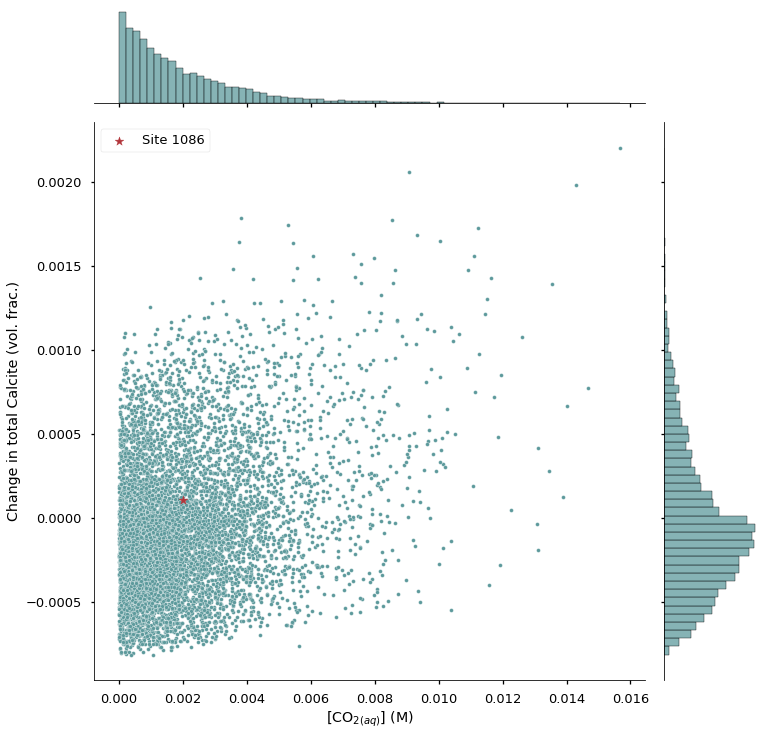

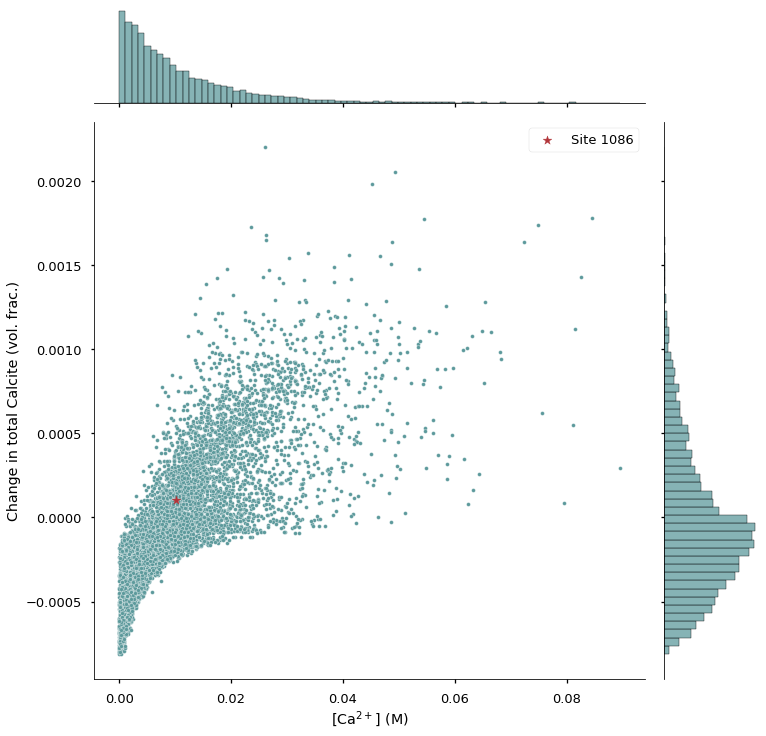

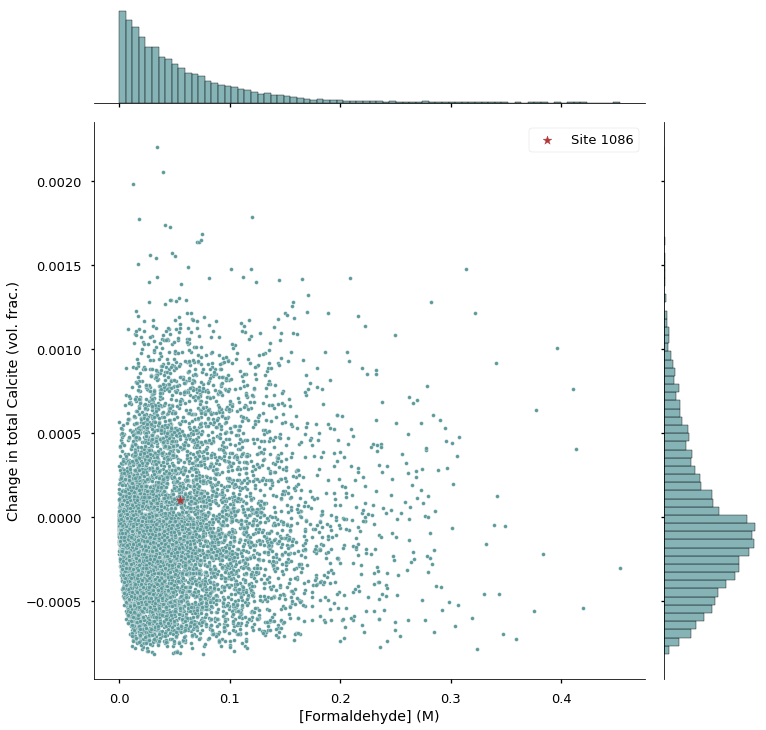

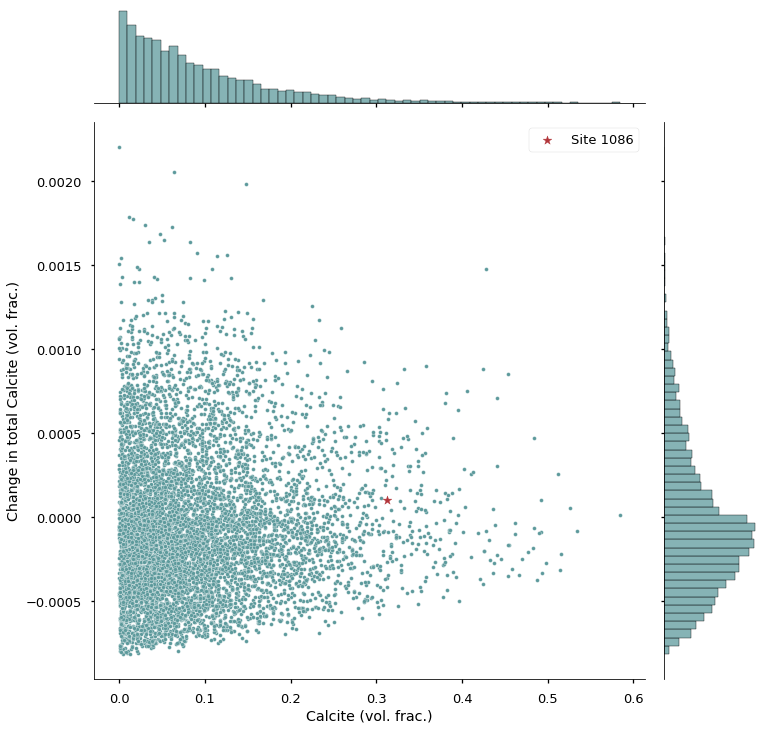

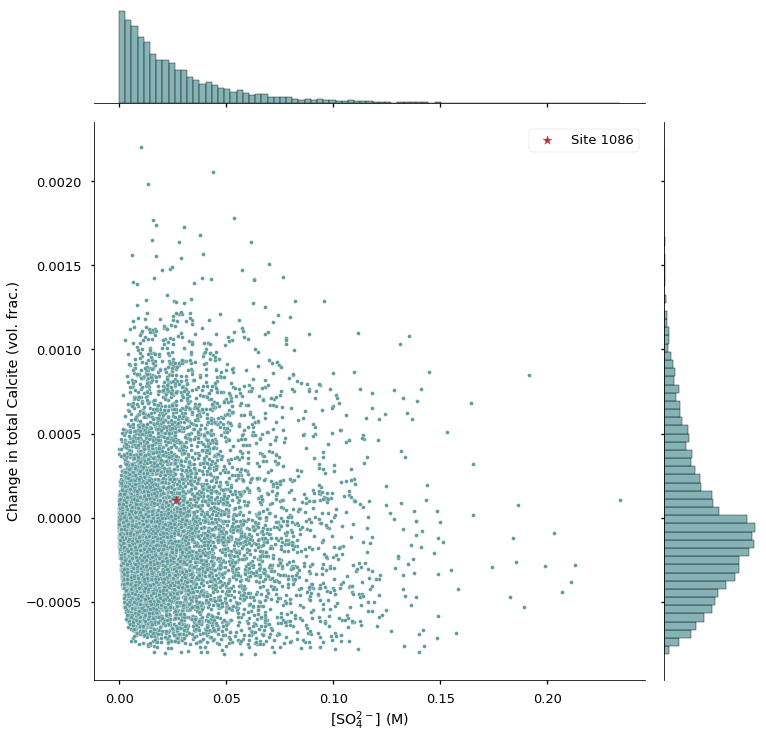

In [14]:
plt.style.use('seaborn-talk')
for i, x_label, x_data, sample_bound, crunch_point in zip((1, 2, 3, 4, 5), ['[CO$_{2(aq)}$] (M)', '[Ca$^{2+}$] (M)', '[Formaldehyde] (M)', 'Calcite (vol. frac.)', '[SO$_4^{2-}$] (M)'],
    [x_train['CO2(aq)'], x_train['Ca++'], x_train['Formaldehyde'], x_train['Calcite'], x_train['SO4--']],
    [[0.0009, 0.0029], [0,0], [0.04, 0.07], [0.08, 0.10], [0.021, 0.031]],
    [2.00e-3, 1.02e-2, 0.55e-01, 0.313, 26.79609e-03]):
    g = sns.jointplot(x=x_data.to_numpy(), y=y_train, kind="scatter", color=[0.3663776351765568, 0.6057935659905949, 0.6135760192192385], marker='o', s=15, height=10)
    g.ax_joint.set_xlabel(x_label)
    g.ax_joint.set_ylabel('Change in total Calcite (vol. frac.)')
    x_mean = x_data.mean()
    g.ax_joint.scatter(crunch_point, 0.0001048420800000005, marker='*', color='#b2353a', label='Site 1086', zorder=2)
    g.ax_joint.legend()
    #g.ax_joint.set_xlim(0, 0.02)
    #g.ax_joint.set_ylim(-0.001, 0.002)
    #g.ax_joint.plot(np.ones(100) * x_mean, np.linspace(-0.0010, 0.0015, 100), '--', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[0], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[1], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    #g.savefig('fig{}.svg'.format(i))

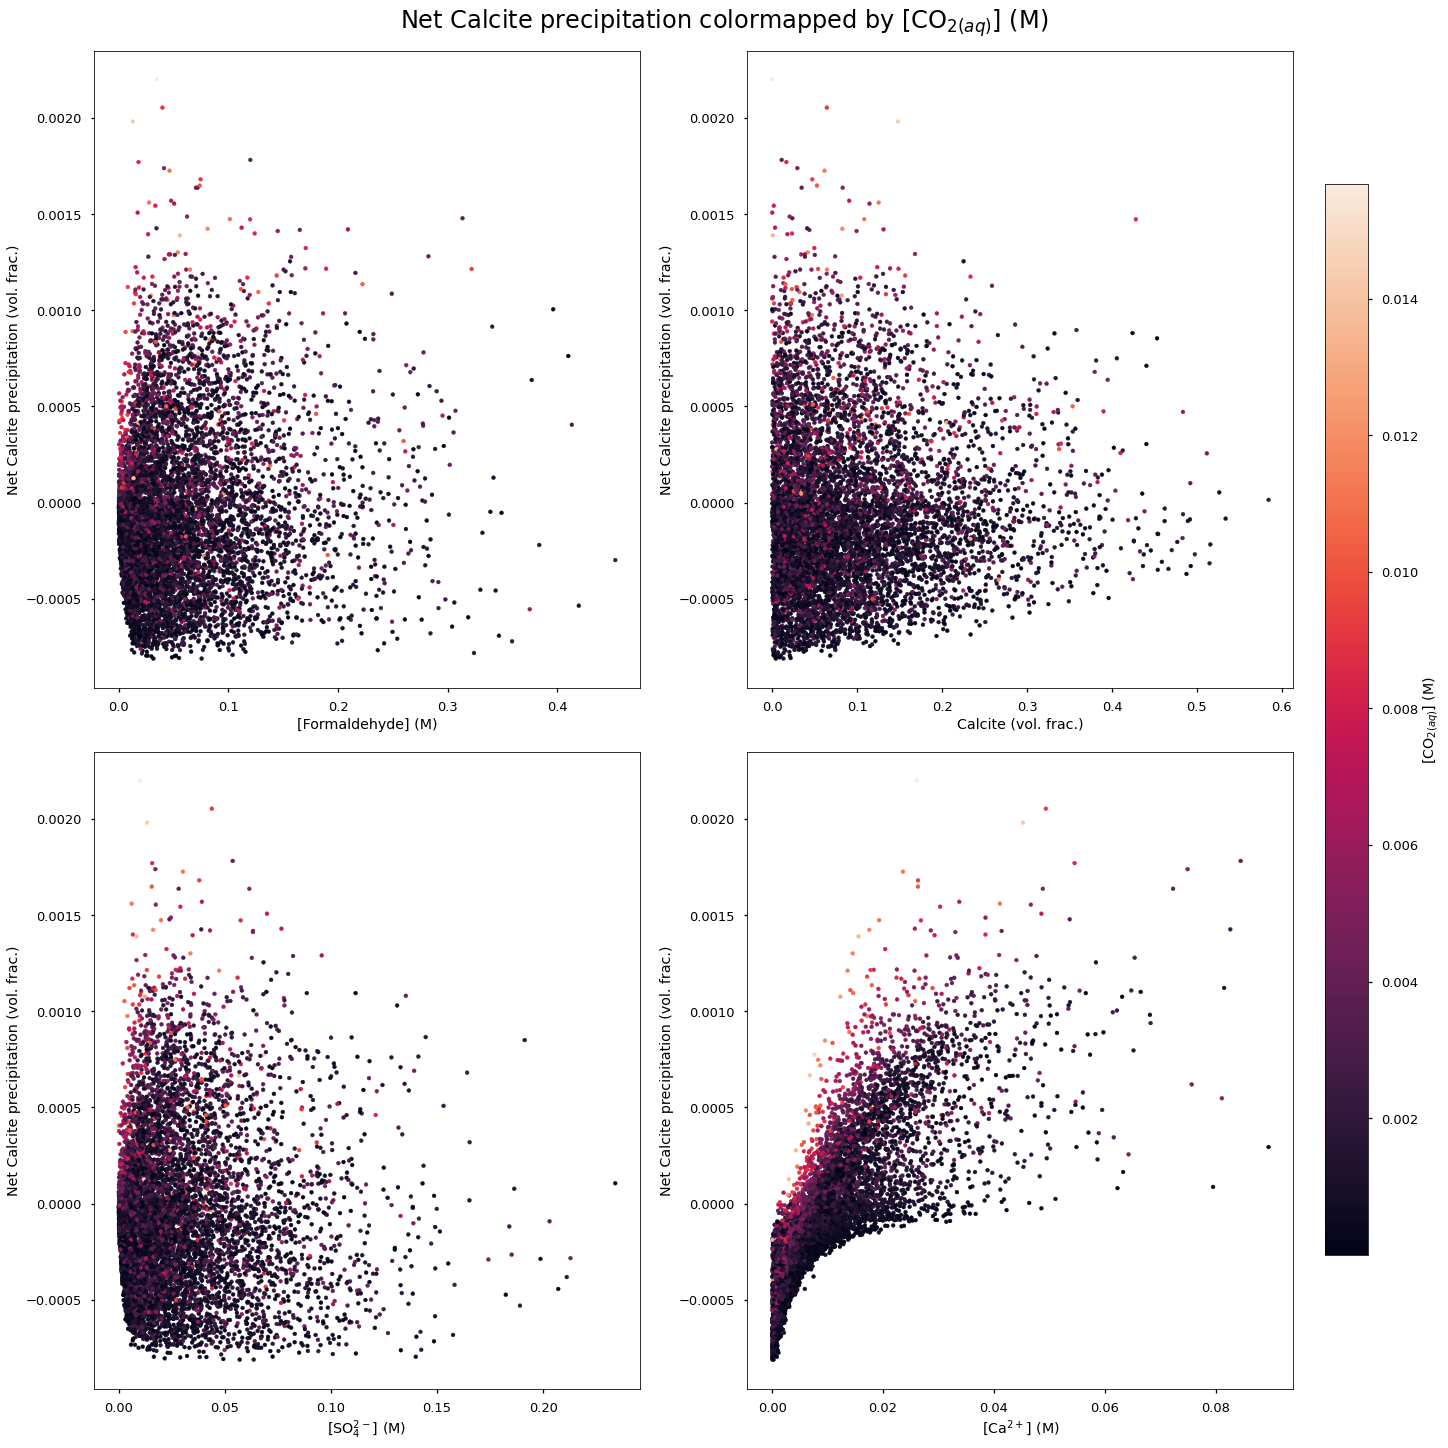

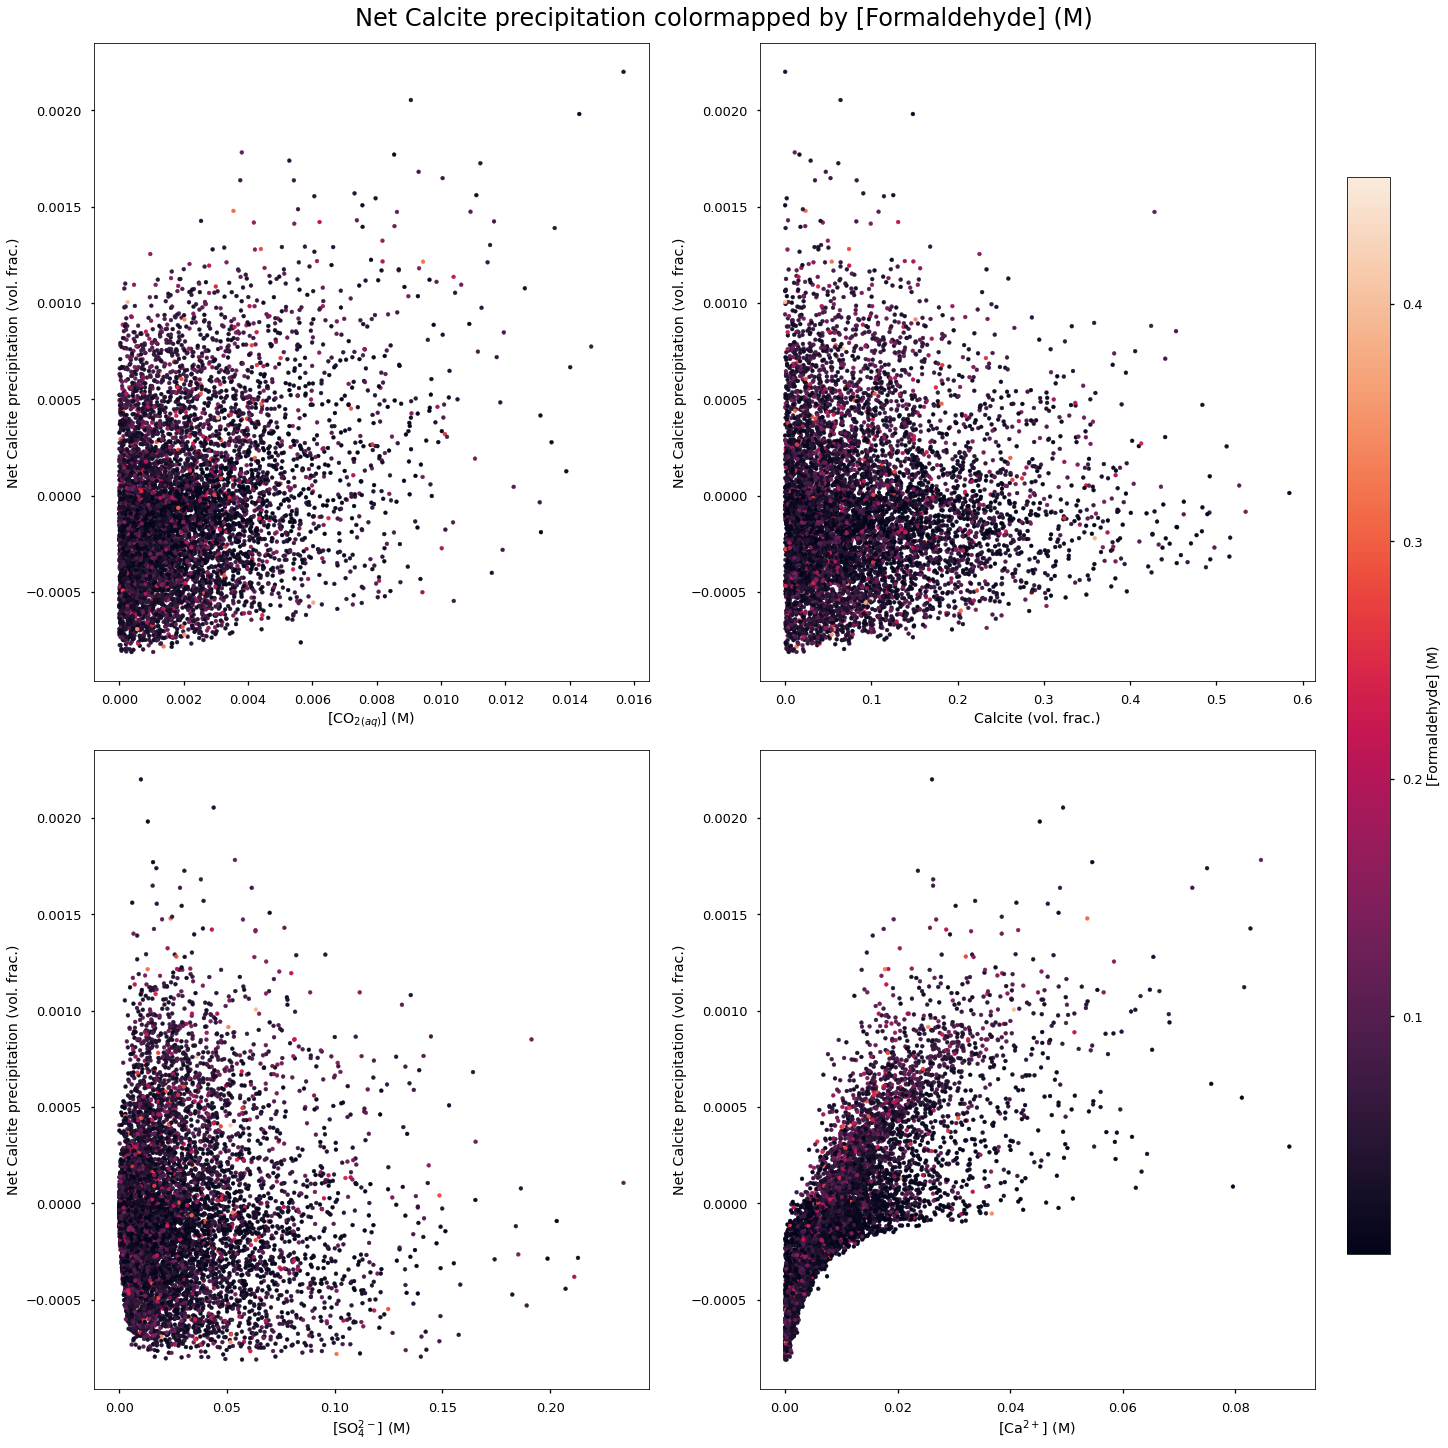

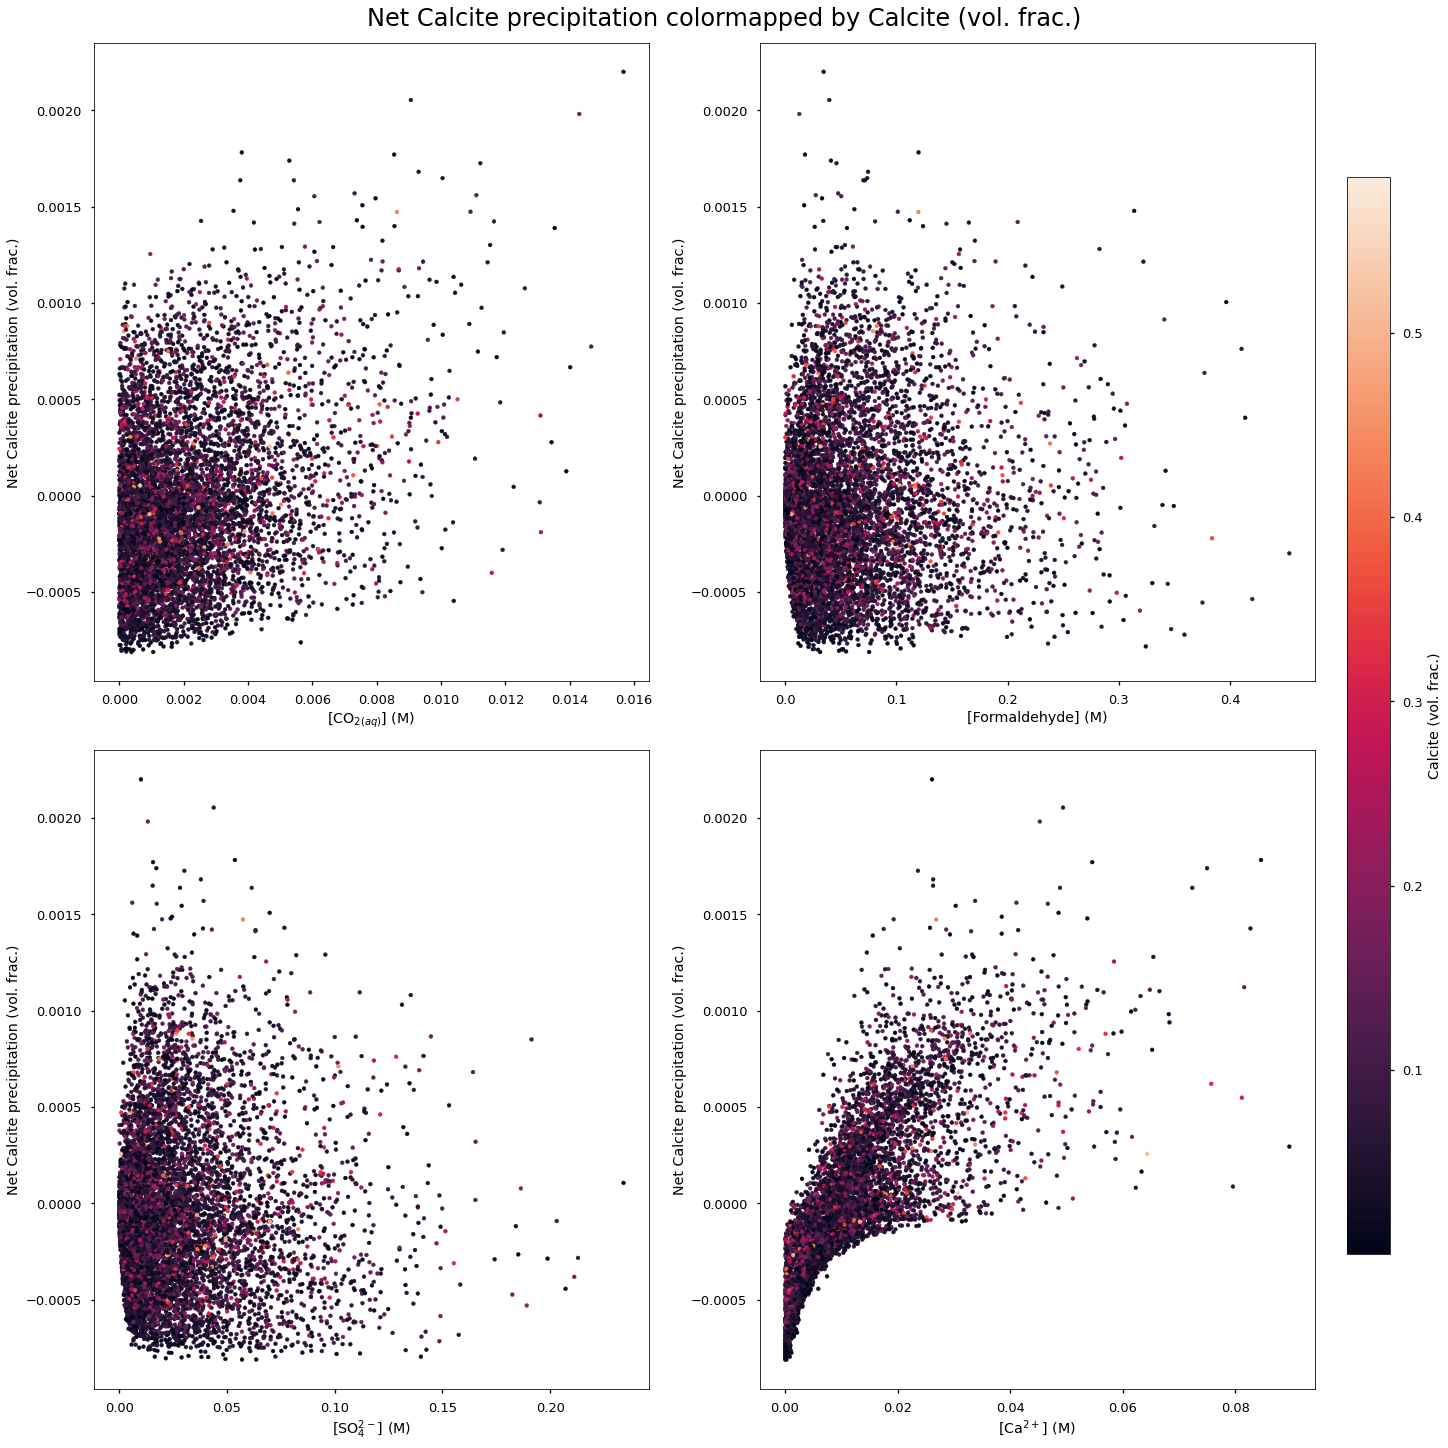

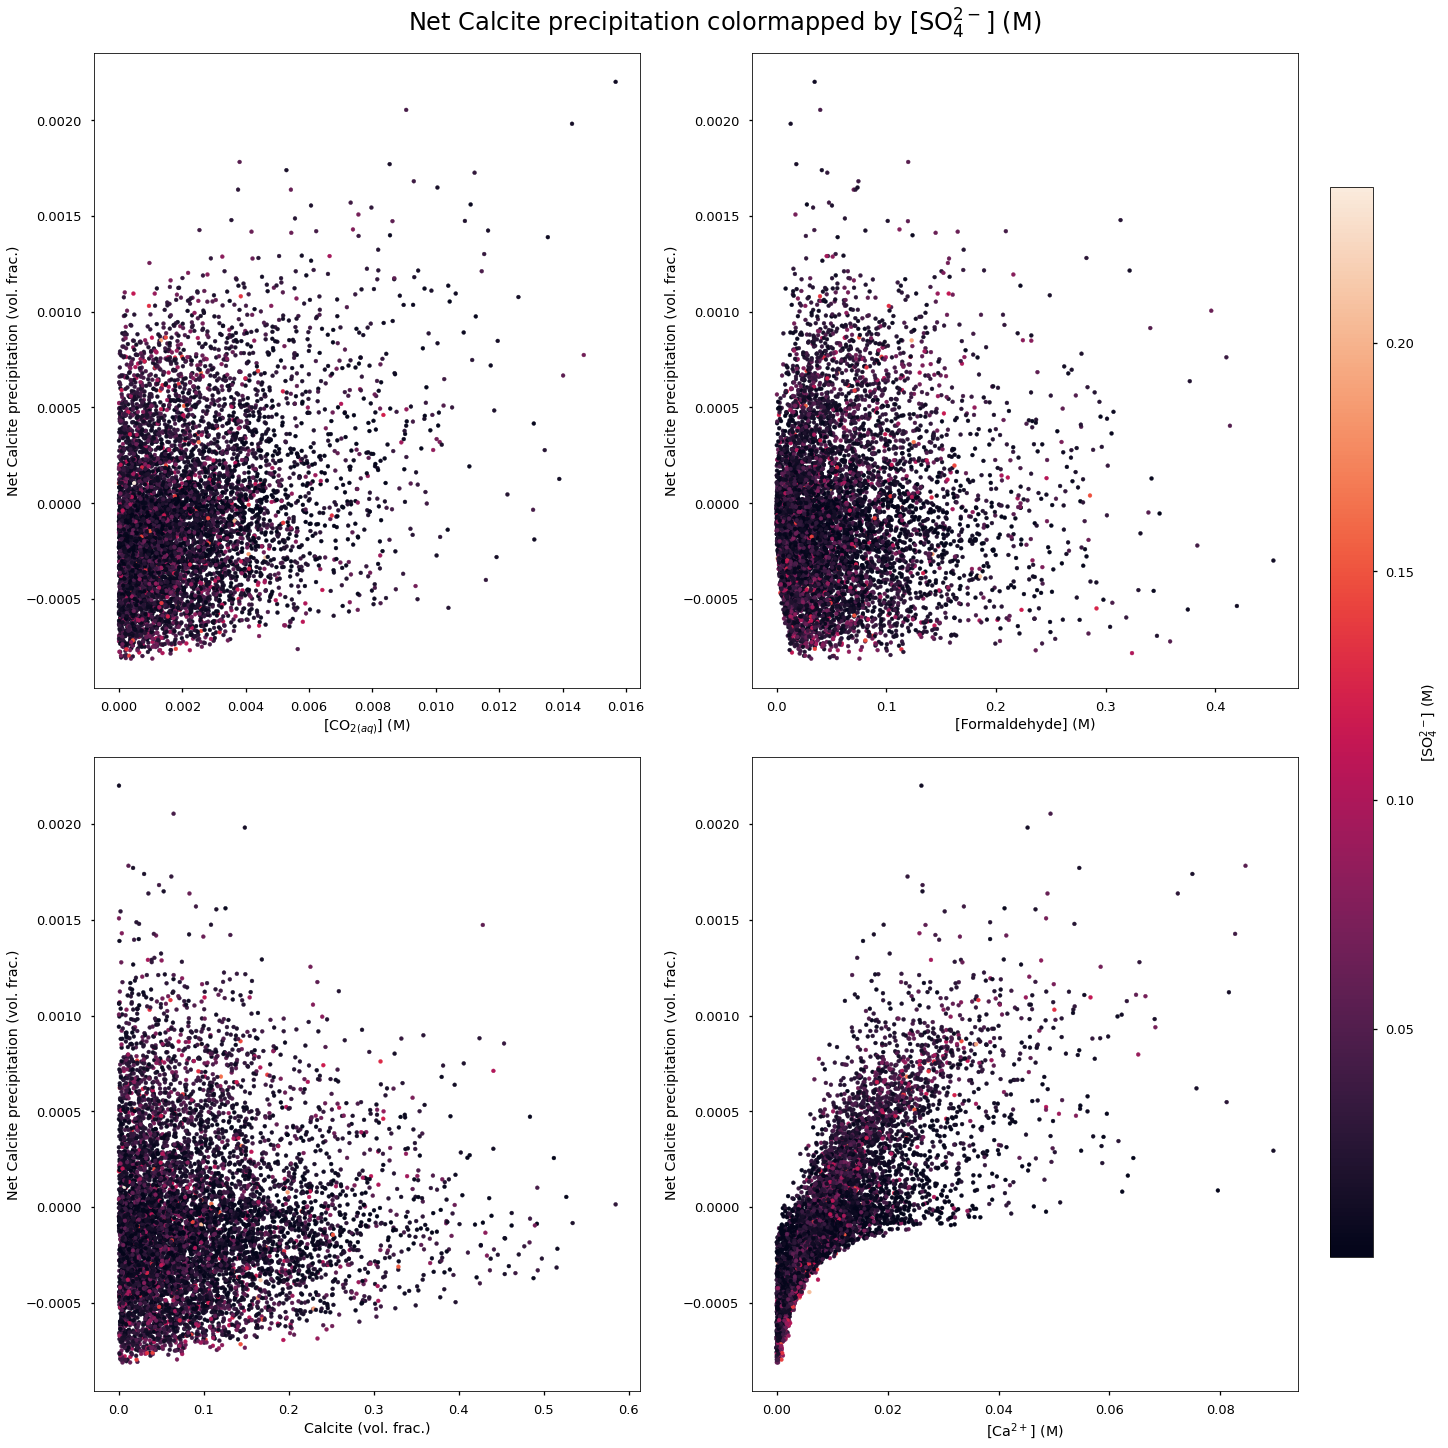

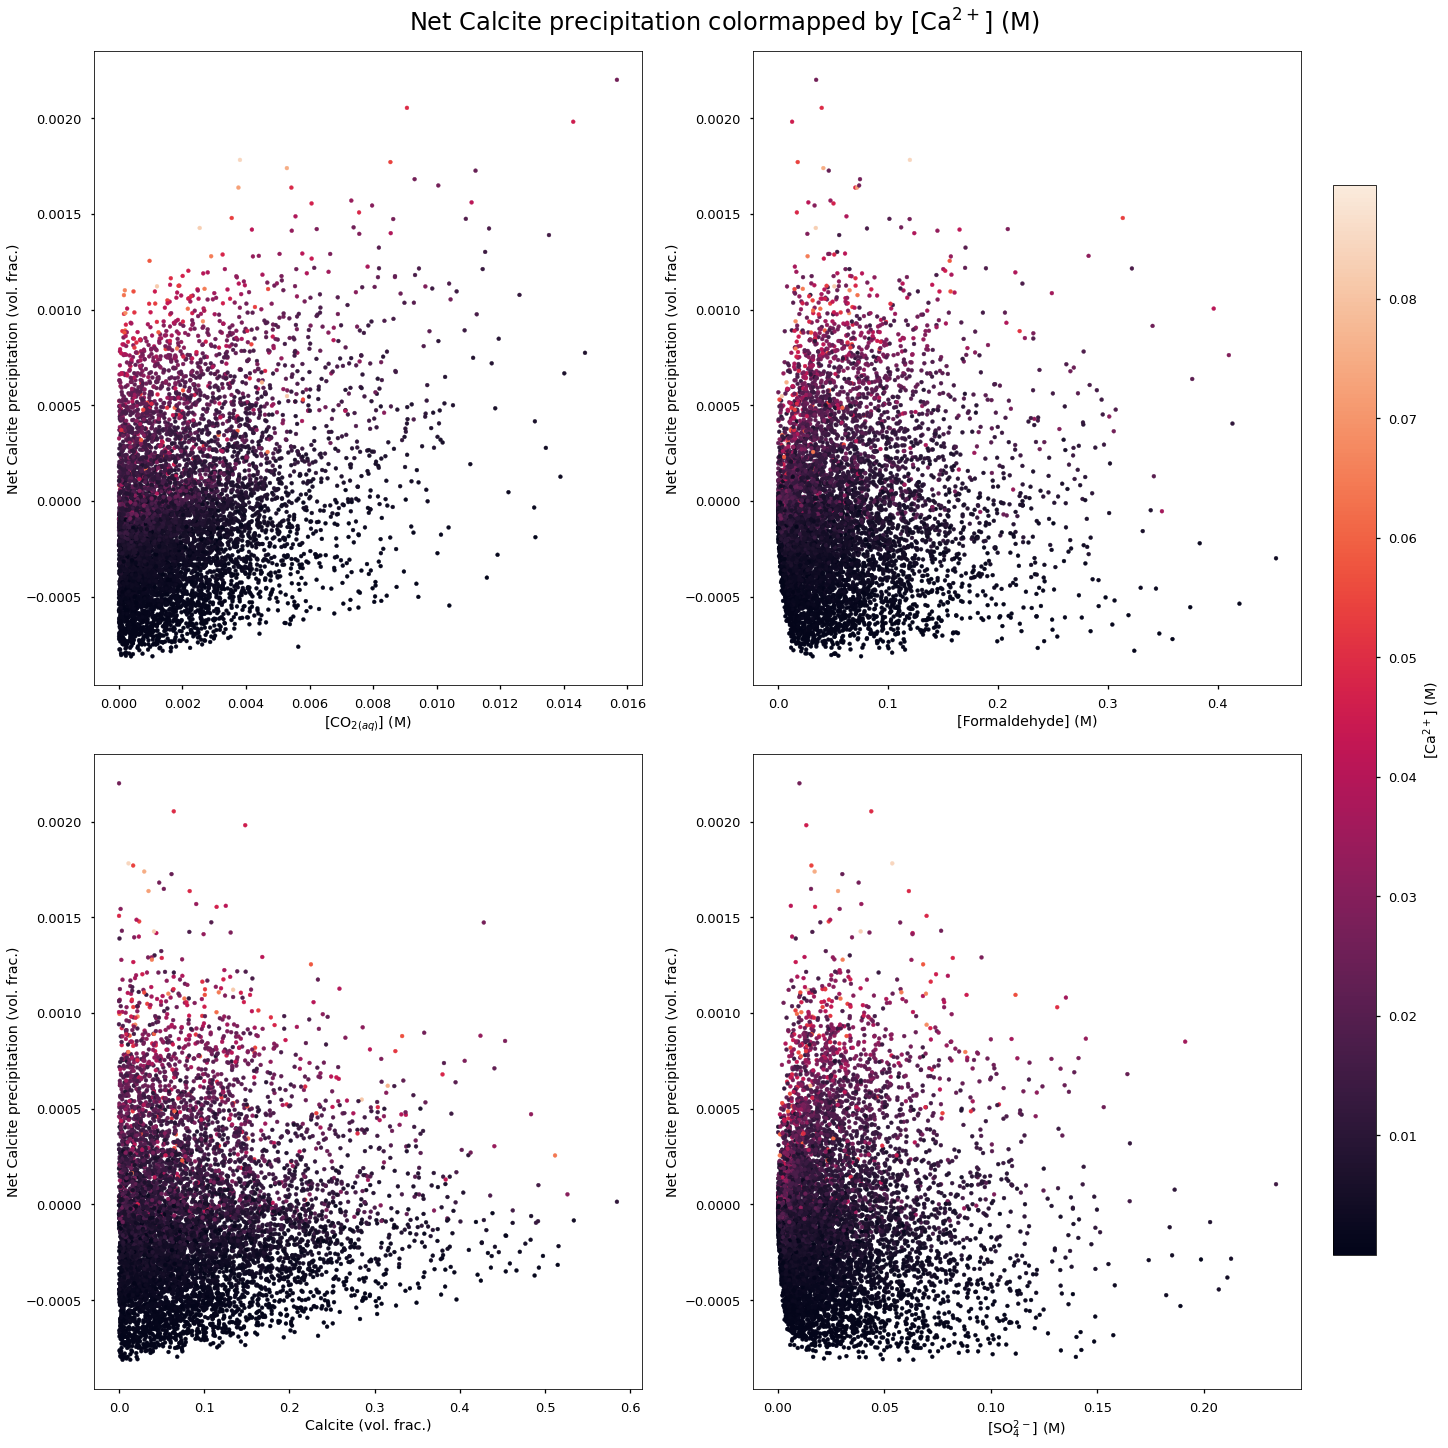

In [82]:
plt.style.use('seaborn-talk')
for i, cmap_var in enumerate(['CO2(aq)', 'Formaldehyde', 'Calcite', 'SO4--', 'Ca++']):
    
    plot_list = ['CO2(aq)', 'Formaldehyde', 'Calcite', 'SO4--', 'Ca++']
    x_labels = ['[CO$_{2(aq)}$] (M)', '[Formaldehyde] (M)', 'Calcite (vol. frac.)', '[SO$_4^{2-}$] (M)', '[Ca$^{2+}$] (M)']

    plot_list.pop(i)    
    cmap_label = x_labels.pop(i)
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True)
    for x_label, species, axis in zip(x_labels, plot_list, ax.reshape(-1)):
        im = axis.scatter(x=x_train[species], y=y_train, c=x_train[cmap_var], cmap='rocket', s=15)
        axis.set_xlabel(x_label)
        axis.set_ylabel('Net Calcite precipitation (vol. frac.)')

    cbar = fig.colorbar(im, ax=ax[:,1], shrink=0.8)
    cbar.set_label(cmap_label)
    fig.suptitle('Net Calcite precipitation colormapped by {}'.format(cmap_label), fontsize=24)
    fig.savefig('shaded_scatter_{}'.format(cmap_var))

# model.layers[0].output

In [195]:
rf.score(x_test, y_test)

0.12280212875904473

In [212]:
with rf[-1].regressor_.model as model:
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = model.loss(y_train, y_pred)
tape.gradient(loss, model.get_weights())

AttributeError: __enter__

In [39]:
(3.13459369E-01 + 6.64547308E-03) - (0.31335679 + 0.00664321)

0.0001048420800000005